# Molecular Fingerprints Applications

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Stef0916/chemoinformatics-bioinformatics/blob/main/cheminformatics-workflow/notebooks/10-Fingerprints-applications.ipynb)

https://doi.org/10.1016/j.drudis.2022.103356

**1. Molecular Similarity and Diversity:**
- Similarity Searching: Given a query molecule, you can search a large database to find molecules that are similar to it. This is often used in drug discovery to find compounds that might have similar biological activities.
- Diversity Selection: When selecting a subset of molecules from a large library (e.g., for experimental testing), fingerprints can help ensure that the chosen set covers a broad range of chemical space.

**2. Virtual Screening:**

Molecular fingerprints are often used to screen large databases of compounds to identify potential drug candidates that are similar to a known active compound.

**3. Compound Clustering:**

Fingerprints can be used to cluster molecules based on their structural similarities. This is often used in drug discovery to organize compound libraries and identify chemically diverse sets.

**4. Structure-Activity Relationship (SAR) Analysis:**

By comparing the fingerprints of active and inactive molecules, researchers can identify structural features that might be crucial for biological activity.

**5. Chemoinformatics & Data Mining:**

Fingerprints are used as features in various machine learning and data mining tasks, like predicting drug-likeness, solubility, or biological activity of molecules.

**6. Compound Classification:**

Molecular fingerprints can be used in machine learning algorithms to classify compounds into different classes based on their activity, toxicity, or other properties.

In [1]:
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 72.0 MB/s eta 0:00:00


In [2]:
!pip install mols2grid #to visualize in a grid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem #Chemistry related RDKit module
from rdkit.Chem import rdMolDescriptors #Molecular descriptors with numerical values
from rdkit.Chem.Draw import IPythonConsole #Molecules visualization with Jupyter
from rdkit.Chem import Draw #2D depiction
from rdkit.Chem import rdDepictor #2D coordinate generation, consistency
from rdkit import DataStructs #RDKit data structure - binary fingerprints
from rdkit.ML.Cluster import Butina #Clusters molecules based on their similarity
from rdkit.Chem import PandasTools #RDKit with Pandas
import mols2grid #Molecule representation in a grid
IPythonConsole.ipython_useSVG = True #Molecules display in SGV in Jupyter
rdDepictor.SetPreferCoordGen(True) #Cleaner 2D coordinate generation

## Moleculer Similarity

I'll use the same dataset as for the Fingerprints notebook, taken directly from a publication about the solubility prediction. Here is the link: https://doi.org/10.1021/ci034243x

However, here I alread performed all the pre-process of the data.

In [4]:
df = pd.read_csv('/content/solubility_clean.csv', usecols=['Compound ID', 'SMILES'])

In [5]:
df

,Compound ID,SMILES
0,"1,1,1,2-Tetrachloroethane",ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",FC(F)(Cl)C(F)(Cl)Cl
...,...,...
1112,vamidothion,CNC(=O)C(C)SCCSP(=O)(OC)OC
1113,Vinclozolin,C=CC1(C)OC(=O)N(c2cc(Cl)cc(Cl)c2)C1=O
1114,Warfarin,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O
1115,Xipamide,Cc1cccc(C)c1NC(=O)c1cc(S(N)(=O)=O)c(Cl)cc1O


### **Query Molecule**


---

The objective is to find a molecular similarity within the dataset. For that, I'll select the first molecule as the query molecule.

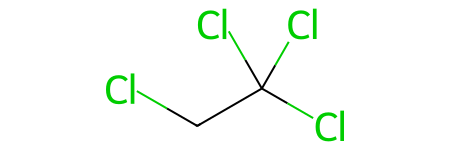

In [6]:
query = AllChem.MolFromSmiles(df.SMILES[0])
query

Now, let's extract the Morgan Fingerprint an store it as an `ExplicitBitVector`

In [7]:
bi ={}

fp_query = AllChem.GetMorganFingerprintAsBitVect(query, 2, nBits=2048, bitInfo=bi)
fp_query

We can also transform it into a numpy array.

In [8]:
fp_query_arr = np.zeros((0,))
DataStructs.ConvertToNumpyArray(fp_query, fp_query_arr)
fp_query_arr

array([0., 0., 0., ..., 0., 0., 0.])

### **DataSet**


---

Now, let's add the column containing molecular objects derived (ROMol) from another column that contains molecular representations, in this case from the SMILES.

,Compound ID,SMILES,ROMol
0,"1,1,1,2-Tetrachloroethane",ClCC(Cl)(Cl)Cl,
1,"1,1,1-Trichloroethane",CC(Cl)(Cl)Cl,
2,"1,1,2,2-Tetrachloroethane",ClC(Cl)C(Cl)Cl,
3,"1,1,2-Trichloroethane",ClCC(Cl)Cl,
4,"1,1,2-Trichlorotrifluoroethane",FC(F)(Cl)C(F)(Cl)Cl,
...,...,...,...
1112,vamidothion,CNC(=O)C(C)SCCSP(=O)(OC)OC,
1113,Vinclozolin,C=CC1(C)OC(=O)N(c2cc(Cl)cc(Cl)c2)C1=O,
1114,Warfarin,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O,
1115,Xipamide,Cc1cccc(C)c1NC(=O)c1cc(S(N)(=O)=O)c(Cl)cc1O,

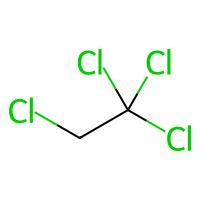
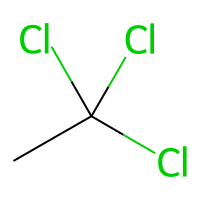
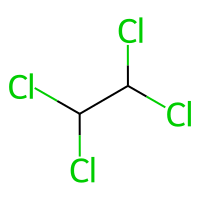
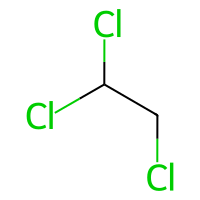
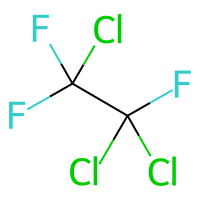
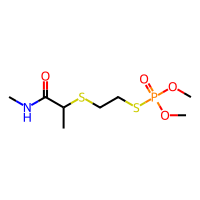
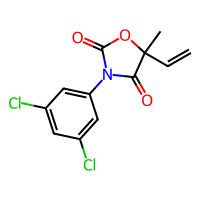
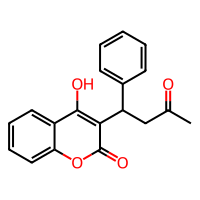
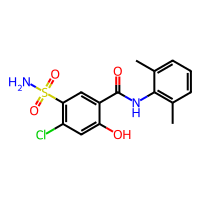
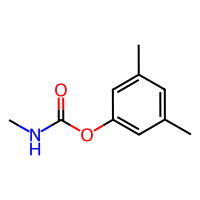

In [9]:
# using pandastools to create molecule from smiles within the dataframe
PandasTools.AddMoleculeColumnToFrame(df, "SMILES")
df

Let's Calculate the fingerprints of all the compounds within the dataset

**Option 1**


---

Here, we're storing the Morgan fingerprints as np.arry directly within the df_morgan DataFrame:

1. The lambda function applies `AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=2048)` to each molecule in the 'ROMol' column, which would also produce an `ExplicitBitVect` object for each molecule.
2. However, when storing this object within a pandas DataFrame, pandas automatically serializes the `ExplicitBitVect` object into its numpy array equivalent to make it more compatible for storage in a DataFrame.

In [10]:
df_morgan = df.copy()
df_morgan['Morgan'] = df_morgan['ROMol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=2048))
df_morgan

,Compound ID,SMILES,ROMol,Morgan
0,"1,1,1,2-Tetrachloroethane",ClCC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abccb370>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"1,1,1-Trichloroethane",CC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abcca8f0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"1,1,2,2-Tetrachloroethane",ClC(Cl)C(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abcca3b0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"1,1,2-Trichloroethane",ClCC(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abcca490>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"1,1,2-Trichlorotrifluoroethane",FC(F)(Cl)C(F)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abccb8b0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
1112,vamidothion,CNC(=O)C(C)SCCSP(=O)(OC)OC,<rdkit.Chem.rdchem.Mol object at 0x7b15abbc22d0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1113,Vinclozolin,C=CC1(C)OC(=O)N(c2cc(Cl)cc(Cl)c2)C1=O,<rdkit.Chem.rdchem.Mol object at 0x7b15abbc2340>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1114,Warfarin,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O,<rdkit.Chem.rdchem.Mol object at 0x7b15abbc23b0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1115,Xipamide,Cc1cccc(C)c1NC(=O)c1cc(S(N)(=O)=O)c(Cl)cc1O,<rdkit.Chem.rdchem.Mol object at 0x7b15abbc2420>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### **Tanimoto Coefficient**


---

Since, we're comparing np.arrays, we can't use the `DataStructs.FingerprintSimilarity` function because it expects fingerprints objects.

In [11]:
def tanimoto_similarity(fp1_arr, fp2_arr):
    intersection = np.dot(fp1_arr, fp2_arr)
    union = np.sum(fp1_arr) + np.sum(fp2_arr) - intersection
    return intersection / union

Tanimoto_similarity = [tanimoto_similarity(fp_query_arr, x) for x in df_morgan['Morgan']]
len(Tanimoto_similarity)

1117

In [12]:
# put the Tanimoto coefficient values into data frame.
df_morgan["Tanimoto Values"] = Tanimoto_similarity
df_morgan

,Compound ID,SMILES,ROMol,Morgan,Tanimoto Values
0,"1,1,1,2-Tetrachloroethane",ClCC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abccb370>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000
1,"1,1,1-Trichloroethane",CC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abcca8f0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.272727
2,"1,1,2,2-Tetrachloroethane",ClC(Cl)C(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abcca3b0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.083333
3,"1,1,2-Trichloroethane",ClCC(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abcca490>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.230769
4,"1,1,2-Trichlorotrifluoroethane",FC(F)(Cl)C(F)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abccb8b0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.230769
...,...,...,...,...,...
1112,vamidothion,CNC(=O)C(C)SCCSP(=O)(OC)OC,<rdkit.Chem.rdchem.Mol object at 0x7b15abbc22d0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.026316
1113,Vinclozolin,C=CC1(C)OC(=O)N(c2cc(Cl)cc(Cl)c2)C1=O,<rdkit.Chem.rdchem.Mol object at 0x7b15abbc2340>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.025641
1114,Warfarin,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O,<rdkit.Chem.rdchem.Mol object at 0x7b15abbc23b0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.022727
1115,Xipamide,Cc1cccc(C)c1NC(=O)c1cc(S(N)(=O)=O)c(Cl)cc1O,<rdkit.Chem.rdchem.Mol object at 0x7b15abbc2420>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.021739


In [13]:
# sort Tanimoto coefficient values in decreasing order
df_morgan_sorted = df_morgan.sort_values(['Tanimoto Values'],ascending=False)
df_morgan_sorted

,Compound ID,SMILES,ROMol,Morgan,Tanimoto Values
0,"1,1,1,2-Tetrachloroethane",ClCC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abccb370>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000
1057,Tetrachloromethane,ClC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abbc0ac0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.333333
571,Dichloromethane,ClCCl,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb33e0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.333333
706,Hexachloroethane,ClC(Cl)(Cl)C(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb6f80>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.300000
23,"1,2-Dichloroethane",ClCCCl,<rdkit.Chem.rdchem.Mol object at 0x7b15abba4270>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.300000
...,...,...,...,...,...
534,Cyclooctanol,OC1CCCCCCC1,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb23b0>,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000
535,Cyclooctyl-5-spirobarbituric acid,O=C1NC(=O)C2(CCCCCCC2)C(=O)N1,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb2420>,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000
536,Cyclopentane,C1CCCC1,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb2490>,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000
537,Cyclopentene,C1=CCCC1,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb2500>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000


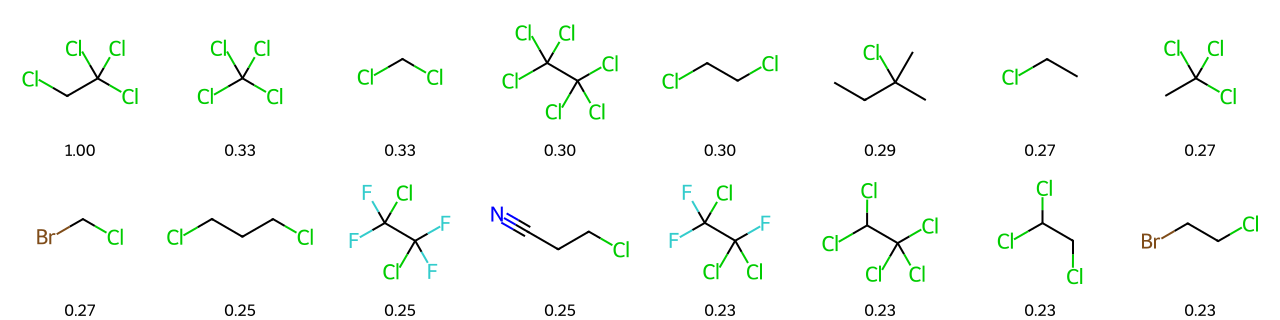

In [14]:
legends = [f"{x:.2f}" for x in df_morgan_sorted['Tanimoto Values'][:16]]

img = Draw.MolsToGridImage([x for x in df_morgan_sorted["ROMol"]][:16],
                           legends=legends,
                           subImgSize=(160,160),
                           molsPerRow=8)
img

**Option 2**


---

We'll work with the Morgan Fingerprints as `ExplicitBitVect`. First, we'll store the fingerprints into a list and then calculate the Tanimoto coefficient using directly the RDKit function, because now we have objects, which is the expected input for this function (and not np.array like in option 1). We need to use the `fp_query` which is an object, and not the `fp_query_array`.

In [45]:
all_Mfpts = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=4096) for mol in df_morgan['ROMol']]
all_Mfpts[:10]

In [46]:
len(all_Mfpts)

1117

In [16]:
Tanimoto_similarity_2 = [DataStructs.FingerprintSimilarity(fp_query, x, metric=DataStructs.TanimotoSimilarity) for x in all_Mfpts]

In [17]:
df_morgan2 = df.copy()
df_morgan2['Tanimoto Values'] = Tanimoto_similarity
df_morgan2

,Compound ID,SMILES,ROMol,Tanimoto Values
0,"1,1,1,2-Tetrachloroethane",ClCC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abccb370>,1.000000
1,"1,1,1-Trichloroethane",CC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abcca8f0>,0.272727
2,"1,1,2,2-Tetrachloroethane",ClC(Cl)C(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abcca3b0>,0.083333
3,"1,1,2-Trichloroethane",ClCC(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abcca490>,0.230769
4,"1,1,2-Trichlorotrifluoroethane",FC(F)(Cl)C(F)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abccb8b0>,0.230769
...,...,...,...,...
1112,vamidothion,CNC(=O)C(C)SCCSP(=O)(OC)OC,<rdkit.Chem.rdchem.Mol object at 0x7b15abbc22d0>,0.026316
1113,Vinclozolin,C=CC1(C)OC(=O)N(c2cc(Cl)cc(Cl)c2)C1=O,<rdkit.Chem.rdchem.Mol object at 0x7b15abbc2340>,0.025641
1114,Warfarin,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O,<rdkit.Chem.rdchem.Mol object at 0x7b15abbc23b0>,0.022727
1115,Xipamide,Cc1cccc(C)c1NC(=O)c1cc(S(N)(=O)=O)c(Cl)cc1O,<rdkit.Chem.rdchem.Mol object at 0x7b15abbc2420>,0.021739


In [18]:
df_morgan2_sorted = df_morgan2.sort_values(['Tanimoto Values'], ascending=False)
df_morgan2_sorted

,Compound ID,SMILES,ROMol,Tanimoto Values
0,"1,1,1,2-Tetrachloroethane",ClCC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abccb370>,1.000000
1057,Tetrachloromethane,ClC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abbc0ac0>,0.333333
571,Dichloromethane,ClCCl,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb33e0>,0.333333
706,Hexachloroethane,ClC(Cl)(Cl)C(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb6f80>,0.300000
23,"1,2-Dichloroethane",ClCCCl,<rdkit.Chem.rdchem.Mol object at 0x7b15abba4270>,0.300000
...,...,...,...,...
534,Cyclooctanol,OC1CCCCCCC1,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb23b0>,0.000000
535,Cyclooctyl-5-spirobarbituric acid,O=C1NC(=O)C2(CCCCCCC2)C(=O)N1,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb2420>,0.000000
536,Cyclopentane,C1CCCC1,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb2490>,0.000000
537,Cyclopentene,C1=CCCC1,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb2500>,0.000000


In [19]:
mols2grid.display(df_morgan2_sorted, subset=["Tanimoto Values"], transform={"Tanimoto Values": lambda x: f"{x:.2f}"})

MolGridWidget()

## Clustering

### Taylor-Butina Clustering

The Taylor-Butina clustering method is a popular and efficient non-hierarchical method for clustering large datasets of molecular fingerprints. It's especially useful in the field of cheminformatics for compound library selection, diversity analysis, and high-throughput screening data analysis.

The basic idea behind Butina clustering is to:

- Pre-compute pairwise similarities between all molecules in the dataset.
- Sort these similarities.
- For each molecule, identify neighbors that are above a certain similarity threshold.
- Create clusters such that the largest unclustered molecule (by neighbor count) becomes the centroid of a new cluster, and all its neighbors are assigned to this cluster.

Step-by-step:

1. Distance Calculation: For every molecule in the dataset, calculate the distance (or dissimilarity, which is $1 - similarity$) to every other molecule. This results in a distance matrix.

2. Sorting: The distances are sorted in ascending order.

3. Thresholding: A threshold for the distance (or similarity) is defined. Any molecule within this threshold distance is considered a neighbor.

4. Centroid Selection: The molecule with the most neighbors is selected as the centroid of the next cluster.

5. Cluster Formation: All neighbors of the centroid (within the threshold) are added to its cluster.

6. Iteration: Steps 4 and 5 are repeated until all molecules are assigned to clusters.

7. Singleton Clusters: Any molecule that doesn't belong to any cluster becomes a singleton cluster.

A great blog entry about this topic: http://practicalcheminformatics.blogspot.com/2021/07/viewing-clustered-chemical-structures.html
From which I took inspiration together with the graet tutorial from Gashaw M. Goshu.

In [20]:
# Inspiration from Pat Walters: https://github.com/PatWalters/workshop/blob/master/clustering/taylor_butina.ipynb
# and Gashaw M. Goshu: https://github.com/gashawmg/Molecular-fingerprints/blob/main/Calculating%20molecular%20fingerprints%20available%20in%20RDkit%20.ipynb

def flexible_butina_cluster(data, cutoff=0.35, precomputed_fps=False, nBits=2048):
    """
    Cluster molecules using the Butina algorithm.

    Parameters:
    - data (list): List of molecules (as RDKit Mol objects) or fingerprints (as BitVects),
                  depending on precomputed_fps.
    - cutoff (float): Distance threshold for clustering.
    - precomputed_fps (bool): Flag to indicate if data contains precomputed fingerprints.
    - nBits (int): Number of bits for the fingerprint. Only relevant if fingerprints need to be computed.

    Returns:
    - list: List of cluster IDs corresponding to each molecule/fingerprint.

    Usage:
    1. If you have precomputed fingerprints:
       >>> results = flexible_butina_cluster(precomputed_fingerprints, precomputed_fps=True)

    2. If you have raw molecules and need to compute fingerprints:
       >>> results = flexible_butina_cluster(list_of_molecules)
    """

    # If fingerprints are not precomputed, compute them
    if not precomputed_fps:
        data = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=nBits) for m in data]

    # Calculate pairwise distances
    dists = []
    ndata = len(data)
    for i in range(1, ndata):
        sims = DataStructs.BulkTanimotoSimilarity(data[i], data[:i])
        dists.extend([1-x for x in sims])

    # Apply Butina clustering
    clusters = Butina.ClusterData(dists, ndata, cutoff, isDistData=True)
    cluster_id_list = [0]*ndata
    for idx, cluster in enumerate(clusters, 1):
        for member in cluster:
            cluster_id_list[member] = idx

    return cluster_id_list

Since, I alread computed the Morgan fingerprints, I'll use it to put it in the previous function.

In [21]:
cluster_id_list = flexible_butina_cluster(all_Mfpts, precomputed_fps=True)
len(np.unique(cluster_id_list))

887

In [22]:
df_cluster = df_morgan.copy()
df_cluster['Cluster Number'] = cluster_id_list
df_cluster

,Compound ID,SMILES,ROMol,Morgan,Tanimoto Values,Cluster Number
0,"1,1,1,2-Tetrachloroethane",ClCC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abccb370>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,887
1,"1,1,1-Trichloroethane",CC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abcca8f0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.272727,886
2,"1,1,2,2-Tetrachloroethane",ClC(Cl)C(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abcca3b0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.083333,885
3,"1,1,2-Trichloroethane",ClCC(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abcca490>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.230769,884
4,"1,1,2-Trichlorotrifluoroethane",FC(F)(Cl)C(F)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abccb8b0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.230769,124
...,...,...,...,...,...,...
1112,vamidothion,CNC(=O)C(C)SCCSP(=O)(OC)OC,<rdkit.Chem.rdchem.Mol object at 0x7b15abbc22d0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.026316,129
1113,Vinclozolin,C=CC1(C)OC(=O)N(c2cc(Cl)cc(Cl)c2)C1=O,<rdkit.Chem.rdchem.Mol object at 0x7b15abbc2340>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.025641,128
1114,Warfarin,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O,<rdkit.Chem.rdchem.Mol object at 0x7b15abbc23b0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.022727,59
1115,Xipamide,Cc1cccc(C)c1NC(=O)c1cc(S(N)(=O)=O)c(Cl)cc1O,<rdkit.Chem.rdchem.Mol object at 0x7b15abbc2420>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.021739,127


In [23]:
# group_by cluster and count structure
df_cluster.groupby('Cluster Number')['ROMol'].count()

Cluster Number
1      12
2       9
3       8
4       7
5       7
       ..
883     1
884     1
885     1
886     1
887     1
Name: ROMol, Length: 887, dtype: int64

In [24]:
# Sort clusters
df_cluster_sorted = df_cluster.sort_values(["Cluster Number"])
df_cluster_sorted

,Compound ID,SMILES,ROMol,Morgan,Tanimoto Values,Cluster Number
109,1-Pentadecanol,CCCCCCCCCCCCCCCO,<rdkit.Chem.rdchem.Mol object at 0x7b15abba6810>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.105263,1
66,1-Butanol,CCCCO,<rdkit.Chem.rdchem.Mol object at 0x7b15abba5540>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.117647,1
77,1-Decanol,CCCCCCCCCCO,<rdkit.Chem.rdchem.Mol object at 0x7b15abba5a10>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.105263,1
79,1-Dodecanol,CCCCCCCCCCCCO,<rdkit.Chem.rdchem.Mol object at 0x7b15abba5af0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.105263,1
81,1-Heptanol,CCCCCCCO,<rdkit.Chem.rdchem.Mol object at 0x7b15abba5bd0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.105263,1
...,...,...,...,...,...,...
6,"1,1-Dichloroethylene",C=C(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abccba70>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.076923,883
3,"1,1,2-Trichloroethane",ClCC(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abcca490>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.230769,884
2,"1,1,2,2-Tetrachloroethane",ClC(Cl)C(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abcca3b0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.083333,885
1,"1,1,1-Trichloroethane",CC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abcca8f0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.272727,886


In [25]:
mols2grid.display(df_cluster, subset=["Cluster Number", "Tanimoto Values"], transform={"Tanimoto Values": lambda x: f"{x:.2f}"})

MolGridWidget()

#### Highest Tanimoto Value in each Cluster


---

Now let's create a new dataframe containing only the molecule from each cluster with the highest Tanimoto Values.

In [26]:
idx = df_cluster.groupby('Cluster Number')['Tanimoto Values'].idxmax()
df_max_tanimoto = df_cluster.loc[idx].sort_values("Cluster Number", ascending=True)

In [27]:
df_max_tanimoto

,Compound ID,SMILES,ROMol,Morgan,Tanimoto Values,Cluster Number
66,1-Butanol,CCCCO,<rdkit.Chem.rdchem.Mol object at 0x7b15abba5540>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.117647,1
710,Hexane,CCCCCC,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb7140>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.071429,2
809,Methyl pentanoate,CCCC(=O)OCC,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb9d20>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.041667,3
973,Propyl butyrate,CCCC(=O)OC,<rdkit.Chem.rdchem.Mol object at 0x7b15abbbe570>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.043478,4
1086,Triamcinolone,CC12C=CC(=O)C=C1CCC1C3CC(O)C(O)(C(=O)CO)C3(C)C...,<rdkit.Chem.rdchem.Mol object at 0x7b15abbc1770>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.016949,5
...,...,...,...,...,...,...
6,"1,1-Dichloroethylene",C=C(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abccba70>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.076923,883
3,"1,1,2-Trichloroethane",ClCC(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abcca490>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.230769,884
2,"1,1,2,2-Tetrachloroethane",ClC(Cl)C(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abcca3b0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.083333,885
1,"1,1,1-Trichloroethane",CC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7b15abcca8f0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.272727,886


Now we have 887 rows, which is the expected since we have 887 different clusters.

In [28]:
mols2grid.display(df_max_tanimoto, subset=["Cluster Number", "Tanimoto Values"], transform={"Tanimoto Values": lambda x: f"{x:.2f}"})

MolGridWidget()

#### Filter Compounds with acid functional group


---

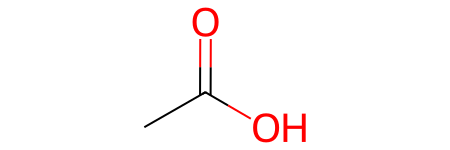

In [29]:
# filter compounds that contain acid functional group
acid = AllChem.MolFromSmiles("CC(=O)O")
acid

In [30]:
dataset_acid = df_max_tanimoto[df_max_tanimoto["ROMol"] >= acid]
dataset_acid

,Compound ID,SMILES,ROMol,Morgan,Tanimoto Values,Cluster Number
809,Methyl pentanoate,CCCC(=O)OCC,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb9d20>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.041667,3
973,Propyl butyrate,CCCC(=O)OC,<rdkit.Chem.rdchem.Mol object at 0x7b15abbbe570>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.043478,4
273,3-Ethanoyloxymethylphenytoin,CC(=O)OCN1C(=O)NC(c2ccccc2)(c2ccccc2)C1=O,<rdkit.Chem.rdchem.Mol object at 0x7b15abbab060>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.023810,6
568,dibutyl sebacate,CCCCOC(=O)CCCCCCCCC(=O)OCCCC,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb3290>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.035714,13
542,Cyhalothrin,CC1(C)C(C=C(Cl)C(F)(F)F)C1C(=O)OC(C#N)c1cccc(O...,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb2730>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.032787,14
569,dibutylphthalate,CCCCOC(=O)c1ccccc1C(=O)OCCCC,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb3300>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.031250,28
657,Ethyl-p-hydroxybenzoate,CCOC(=O)c1ccc(O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb5a10>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.033333,31
799,Methyl butyrate,CCCOC(=O)CC,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb98c0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.041667,44
1053,testosterone propionate,CCC(=O)OC1CCC2C3CCC4=CC(=O)CCC4(C)C3CCC12C,<rdkit.Chem.rdchem.Mol object at 0x7b15abbc0900>,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.018182,65
972,Propyl acetate,CCCOC(C)=O,<rdkit.Chem.rdchem.Mol object at 0x7b15abbbe500>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.043478,75


In [31]:
mols2grid.display(dataset_acid, subset=["Cluster Number", "Tanimoto Values"], transform={"Tanimoto Values": lambda x: f"{x:.2f}"})

MolGridWidget()

#### Murcko Scaffold


---

The Murcko scaffold, also known as the Bemis-Murcko scaffold or generic framework, refers to a molecular scaffold derived by removing side chains from a molecule, leaving just the ring systems and linkers connecting them. This concept was introduced by Gregory A. Bemis and Mark A. Murcko in 1996 as a way to categorize molecules based on their core structures.<sup>[10](http://www.ncbi.nlm.nih.gov/pubmed/8709122)</sup>

The scaffold of a molecule represents its core structure, without any substituents or decorations.

In [32]:
from rdkit.Chem.Scaffolds import MurckoScaffold

In [33]:
def get_murcko_scaffold(smiles_string):
    """
    Extracts the Murcko scaffold from a given SMILES string.

    Parameters:
    - smiles_string (str): The SMILES representation of the molecule.

    Returns:
    - str: The SMILES representation of the Murcko scaffold of the molecule.

    Example:
    >>> get_murcko_scaffold("CCO")
    'C-C'
    """

    mol = Chem.MolFromSmiles(smiles_string)
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    return Chem.MolToSmiles(scaffold)

From the already filtered molecules within the `dataset_acid`, now we'll find for the Murcko Scaffold.

In [34]:
dataset_murcko = dataset_acid.copy()
dataset_murcko['Murcko Scaffold'] = dataset_murcko['SMILES'].apply(get_murcko_scaffold)

In [35]:
dataset_murcko.head()

,Compound ID,SMILES,ROMol,Morgan,Tanimoto Values,Cluster Number,Murcko Scaffold
809,Methyl pentanoate,CCCC(=O)OCC,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb9d20>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.041667,3,
973,Propyl butyrate,CCCC(=O)OC,<rdkit.Chem.rdchem.Mol object at 0x7b15abbbe570>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.043478,4,
273,3-Ethanoyloxymethylphenytoin,CC(=O)OCN1C(=O)NC(c2ccccc2)(c2ccccc2)C1=O,<rdkit.Chem.rdchem.Mol object at 0x7b15abbab060>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.023810,6,O=C1NC(=O)C(c2ccccc2)(c2ccccc2)N1
568,dibutyl sebacate,CCCCOC(=O)CCCCCCCCC(=O)OCCCC,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb3290>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.035714,13,
542,Cyhalothrin,CC1(C)C(C=C(Cl)C(F)(F)F)C1C(=O)OC(C#N)c1cccc(O...,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb2730>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.032787,14,O=C(OCc1cccc(Oc2ccccc2)c1)C1CC1


In [36]:
# Convert the strings in the 'Murcko Scaffold' column to RDKit molecule objects
dataset_murcko['Murcko_Mol'] = dataset_murcko['Murcko Scaffold'].apply(Chem.MolFromSmiles)
dataset_murcko.head()

,Compound ID,SMILES,ROMol,Morgan,Tanimoto Values,Cluster Number,Murcko Scaffold,Murcko_Mol
809,Methyl pentanoate,CCCC(=O)OCC,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb9d20>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.041667,3,,<rdkit.Chem.rdchem.Mol object at 0x7b15aa2fa880>
973,Propyl butyrate,CCCC(=O)OC,<rdkit.Chem.rdchem.Mol object at 0x7b15abbbe570>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.043478,4,,<rdkit.Chem.rdchem.Mol object at 0x7b15aa2fb530>
273,3-Ethanoyloxymethylphenytoin,CC(=O)OCN1C(=O)NC(c2ccccc2)(c2ccccc2)C1=O,<rdkit.Chem.rdchem.Mol object at 0x7b15abbab060>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.023810,6,O=C1NC(=O)C(c2ccccc2)(c2ccccc2)N1,<rdkit.Chem.rdchem.Mol object at 0x7b15aa2fba70>
568,dibutyl sebacate,CCCCOC(=O)CCCCCCCCC(=O)OCCCC,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb3290>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.035714,13,,<rdkit.Chem.rdchem.Mol object at 0x7b15aa2fa0a0>
542,Cyhalothrin,CC1(C)C(C=C(Cl)C(F)(F)F)C1C(=O)OC(C#N)c1cccc(O...,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb2730>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.032787,14,O=C(OCc1cccc(Oc2ccccc2)c1)C1CC1,<rdkit.Chem.rdchem.Mol object at 0x7b15aa2faff0>


In [37]:
dataset_murcko = dataset_murcko[dataset_murcko['Murcko_Mol'].apply(lambda x: x.GetNumAtoms() > 0 if x else False)]
dataset_murcko.head()

,Compound ID,SMILES,ROMol,Morgan,Tanimoto Values,Cluster Number,Murcko Scaffold,Murcko_Mol
273,3-Ethanoyloxymethylphenytoin,CC(=O)OCN1C(=O)NC(c2ccccc2)(c2ccccc2)C1=O,<rdkit.Chem.rdchem.Mol object at 0x7b15abbab060>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.023810,6,O=C1NC(=O)C(c2ccccc2)(c2ccccc2)N1,<rdkit.Chem.rdchem.Mol object at 0x7b15aa2fba70>
542,Cyhalothrin,CC1(C)C(C=C(Cl)C(F)(F)F)C1C(=O)OC(C#N)c1cccc(O...,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb2730>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.032787,14,O=C(OCc1cccc(Oc2ccccc2)c1)C1CC1,<rdkit.Chem.rdchem.Mol object at 0x7b15aa2faff0>
569,dibutylphthalate,CCCCOC(=O)c1ccccc1C(=O)OCCCC,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb3300>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.031250,28,c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7b15aa2fb450>
657,Ethyl-p-hydroxybenzoate,CCOC(=O)c1ccc(O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7b15abbb5a10>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.033333,31,c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7b15aa2fb140>
1053,testosterone propionate,CCC(=O)OC1CCC2C3CCC4=CC(=O)CCC4(C)C3CCC12C,<rdkit.Chem.rdchem.Mol object at 0x7b15abbc0900>,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.018182,65,O=C1C=C2CCC3C4CCCC4CCC3C2CC1,<rdkit.Chem.rdchem.Mol object at 0x7b15aa2fa490>


In [38]:
mols2grid.display(dataset_murcko, subset=["Cluster Number", "Murcko Scaffold", "Compound ID"])

MolGridWidget()

In [39]:
common_scaffolds = dataset_murcko['Murcko Scaffold'].value_counts()
common_scaffolds

c1ccccc1                                                                  12
O=C1C=C2CCC3C4CCCC4CCC3C2CC1                                               2
c1ccc(Cc2ccccc2)cc1                                                        2
O=C(OCc1cccc(Oc2ccccc2)c1)C1CC1                                            2
O=C1NC(=O)C(c2ccccc2)(c2ccccc2)N1                                          1
O=C1CCCC(CCC2CC=CC3=CCCCC32)O1                                             1
O=S(=O)(NNc1ncccn1)c1ccccc1                                                1
c1ccc(Cn2ccnc2)cc1                                                         1
O=C1OCC2C(OC3CCC4OCOCC4O3)c3cc4c(cc3C(c3ccccc3)C12)OCO4                    1
O=C(Cc1ccccc1)OCc1cccc(Oc2ccccc2)c1                                        1
O=C(CNc1ccccc1)OCc1cccc(Oc2ccccc2)c1                                       1
c1ccc(Nc2ccnc3ccccc23)cc1                                                  1
c1ccncc1                                                                   1

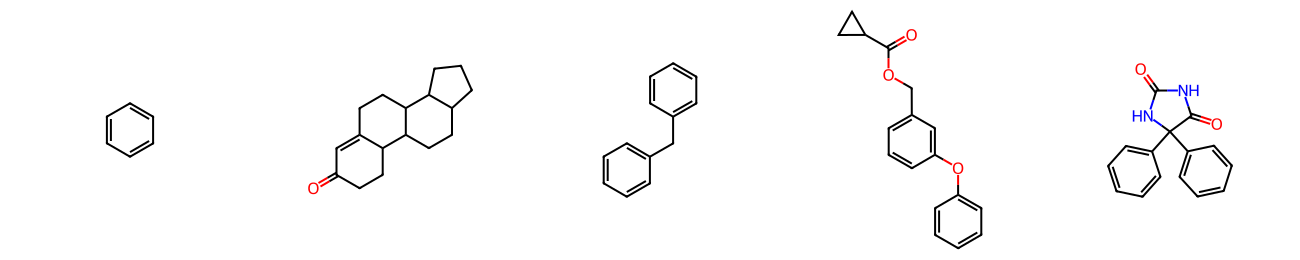

In [40]:
top_scaffolds = common_scaffolds.head(5).index
mols_to_draw = [Chem.MolFromSmiles(scaffold) for scaffold in top_scaffolds]

Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, subImgSize=(260,260))

In [41]:
selected_scaffold = top_scaffolds[1]
matching_molecules = dataset_murcko[dataset_murcko['Murcko Scaffold'] == selected_scaffold]

In [42]:
matching_molecules

,Compound ID,SMILES,ROMol,Morgan,Tanimoto Values,Cluster Number,Murcko Scaffold,Murcko_Mol
1053,testosterone propionate,CCC(=O)OC1CCC2C3CCC4=CC(=O)CCC4(C)C3CCC12C,<rdkit.Chem.rdchem.Mol object at 0x7b15abbc0900>,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.018182,65,O=C1C=C2CCC3C4CCCC4CCC3C2CC1,<rdkit.Chem.rdchem.Mol object at 0x7b15aa2fa490>
866,norethindrone acetate,C#CC1(OC(C)=O)CCC2C3CCC4=CC(=O)CCC4C3CCC21C,<rdkit.Chem.rdchem.Mol object at 0x7b15abbbb610>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000,295,O=C1C=C2CCC3C4CCCC4CCC3C2CC1,<rdkit.Chem.rdchem.Mol object at 0x7b15aa1d77d0>


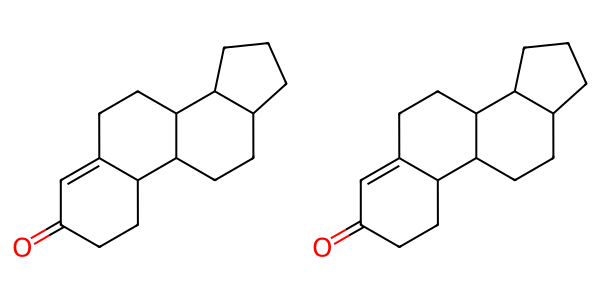

In [43]:
# Visualize the molecules
img = Draw.MolsToGridImage(matching_molecules['Murcko_Mol'].tolist(), molsPerRow=2, subImgSize=(300,300))
img